In [1]:
import keras.backend as K
import numpy as np


def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print('shape为',layer_activations.shape)
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    """
    Suppose input_dim = 10  time_steps = 6
    formed one  x 6 x 10 The data of each step 6 dimension is the same as y
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:,:,attention_dim] =  np.tile(y[:], (1, time_steps))


    return x,y

Using TensorFlow backend.


In [37]:
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model

#from attention_utils import get_activations
from keras.layers import merge
from keras.layers import Multiply
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul



def create_dataset(dataset, look_back):
    '''
    Processing the data
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

# Multidimensional normalization returns data and maximum and minimum values
def NormalizeMult(data):
    #normalize Used for denormalization
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    print(normalize.shape)
    for i in range(0,data.shape[1]):
        #Column i
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

# Multidimensional denormalization
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data


def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #For GPU you can use CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [9]:
!rm -rf pollution.csv
!wget https://github.com/PatientEz/CNN-BiLSTM-Attention-Time-Series-Prediction_Keras/raw/master/pollution.csv

--2020-06-29 06:02:18--  https://github.com/PatientEz/CNN-BiLSTM-Attention-Time-Series-Prediction_Keras/raw/master/pollution.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PatientEz/CNN-BiLSTM-Attention-Time-Series-Prediction_Keras/master/pollution.csv [following]
--2020-06-29 06:02:18--  https://raw.githubusercontent.com/PatientEz/CNN-BiLSTM-Attention-Time-Series-Prediction_Keras/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2301672 (2.2M) [text/plain]
Saving to: ‘pollution.csv’

pollution.csv       100%[===================>]   2.19M  10.1MB/s    in 0.2s    

2020-06-29 0

In [19]:
data = pd.read_csv("./pollution.csv")
data.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [20]:
data = data.drop(['date','wnd_dir'], axis = 1)
print(data.columns)
print(data.shape)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain'], dtype='object')
(43800, 7)


In [21]:
INPUT_DIMS = 7
TIME_STEPS = 20
lstm_units = 64

#Normalized
data,normalize = NormalizeMult(data)
pollution_data = data[:,0].reshape(len(data),1)

train_X, _ = create_dataset(data,TIME_STEPS)
_ , train_Y = create_dataset(pollution_data,TIME_STEPS)

print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
m.compile(optimizer='adam', loss='mse')
m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.1)
#m.save("./model.h5")
#np.save("normalize.npy",normalize)

(7, 2)
(43779, 20, 7) (43779, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 20, 7)        0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 20, 64)       512         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 20, 64)       0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 20, 128)      66048       dropout_7[0][0]                  
___________________________________________________________

In [69]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("./pollution.csv")
df = df.drop(['date','wnd_dir'], axis = 1)
train_size = int(len(df)*0.8)
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]
#train, test = train_test_split(df, test_size=0.1)
print("len(train):",len(train))
print("len(test):",len(test))

len(train): 35040
len(test): 8760


In [63]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [64]:
%rm model.h5

rm: cannot remove 'model.h5': No such file or directory


In [71]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model.h5'
# TRAIN
INPUT_DIMS = 7
TIME_STEPS = 20
lstm_units = 64

#Normalized
train,normalize = NormalizeMult(train)
pollution_data = train[:,0].reshape(len(train),1)

train_X, _ = create_dataset(train,TIME_STEPS)
_ , train_Y = create_dataset(pollution_data,TIME_STEPS)
print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
#m.compile(optimizer='adam', loss='mse')
m.compile(loss='mse', optimizer='adam',metrics=['mae',r2_keras])

# fit the network
history =  m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.1)
#history = m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.05, verbose=2,
#          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                       ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#          )

(7, 2)
(35019, 20, 7) (35019, 1)
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 20, 7)        0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 20, 64)       512         input_17[0][0]                   
__________________________________________________________________________________________________
dropout_33 (Dropout)            (None, 20, 64)       0           conv1d_17[0][0]                  
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 20, 128)      66048       dropout_33[0][0]                 
__________________________________________________________

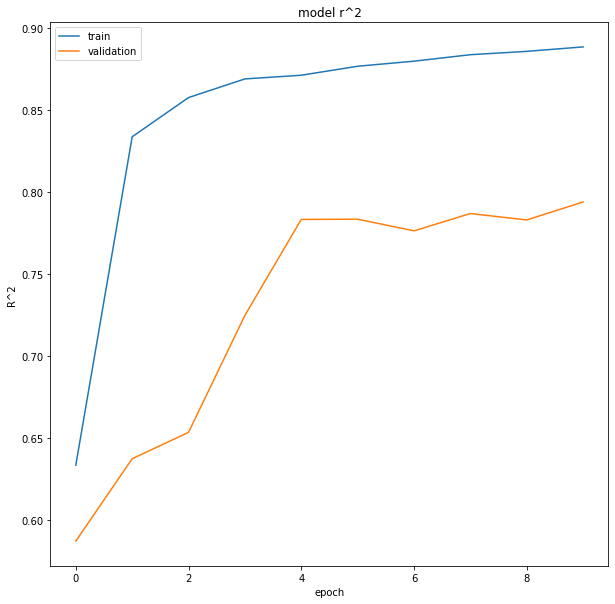

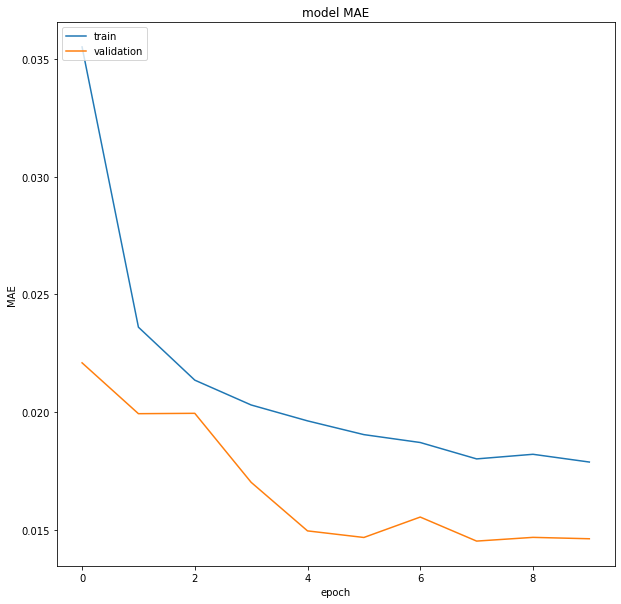

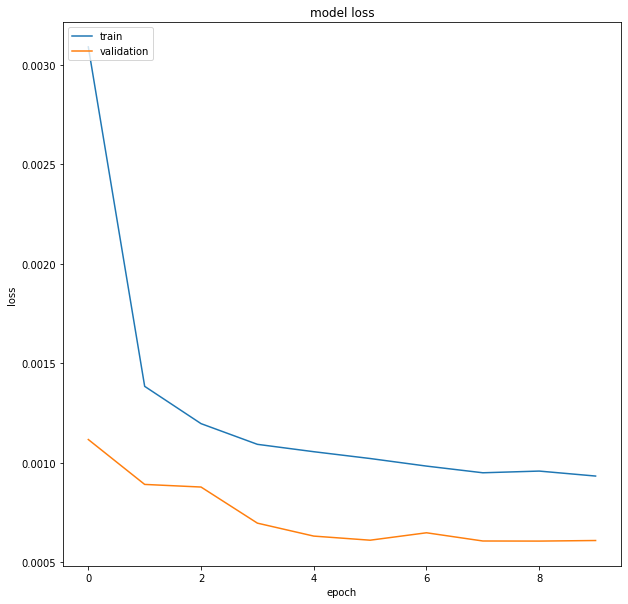

In [72]:
import matplotlib.pyplot as plt

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [73]:
# TEST
test,normalize = NormalizeMult(test)
pollution_test = test[:,0].reshape(len(test),1)

test_X, _ = create_dataset(test,TIME_STEPS)
_ , test_Y = create_dataset(pollution_test,TIME_STEPS)
print(test_X.shape,test_Y.shape)

(7, 2)
(8739, 20, 7) (8739, 1)


In [74]:
# Prediction
scores_test = m.evaluate([test_X], test_Y, verbose=2)

In [75]:
scores_test

[0.0014314372724553543, 0.020876474678516388, 0.5813599228858948]

In [76]:
results = m.predict([test_X])

In [77]:
results

array([[0.05950901],
       [0.0903574 ],
       [0.10436197],
       ...,
       [0.01074445],
       [0.01092879],
       [0.01012178]], dtype=float32)

In [61]:
test_Y

array([[0.02012072],
       [0.        ],
       [0.12877264],
       ...,
       [0.12374245],
       [0.02012072],
       [0.20623742]])

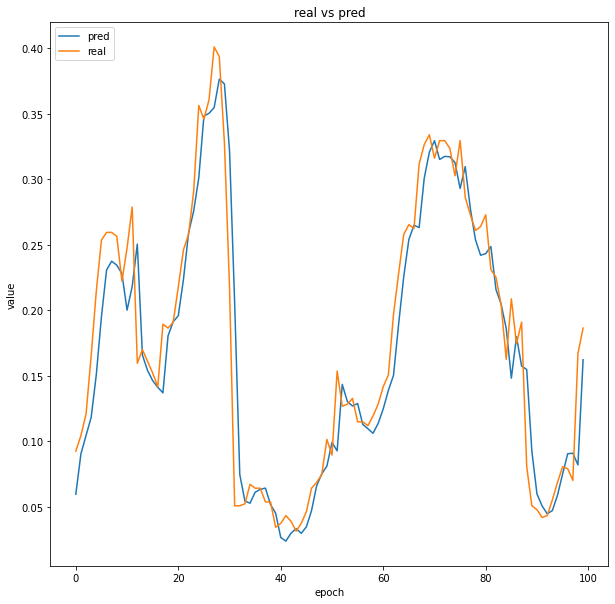

In [79]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(results[:100])
plt.plot(test_Y[:100])
plt.title('real vs pred')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['pred', 'real'], loc='upper left')
plt.show()